In [2]:
print("Hello World")

Hello World


In [3]:
import numpy as np
import matplotlib.pyplot as plt   
from atasi import AtasiNet     

In [4]:

fc = 14.25e9 #Hz
lambda_c = 0.021 #m
delta_D = 0.084 #m
R0 = 400 #m
theta = 45*np.pi/180 #rad
n_antennas = 8 #number of antennas
n_samples = 1000 #number of samples
n_grids = 200 #number of grids (of different height cells)
max_height = 200 #m

In [9]:
def generate_backscatter_coefficients(height=None):
	if height == None : 
		height = np.random.choice([k for k in range(200)])
	A = min(max(np.abs(np.random.rayleigh(scale=2, size=1)[0]), 1), 4)

	phi = np.random.uniform(0, 2 * np.pi, size=1)[0]
	gamma_ = A * np.exp(1j * phi)
	gamma = np.zeros(n_grids,dtype=complex)
	gamma[height] = gamma_
	return gamma

#referred to as A in the model implementation part
#baselines in gamma-net go from -135 to 135 in 25 steps
def compute_baseline_lengths():
    return np.linspace (-135,135,25)

def compute_measurement_matrix(baselines, num_grids, wavelength, R0):
    s = np.linspace(0, max_height, num_grids)  
    D = np.exp(1j * 4 * np.pi * np.outer(baselines, s) / (wavelength * R0))
    return D

#ToDo : compute 11 levels of noise with SNR from 0 to 30 dB --> find the right gwn each time
def simulate_backscattered_signal(gamma, D):
    return np.dot(D, gamma)

def double_scatterer(height1,height2):
    gamma1 = generate_backscatter_coefficients(height1)
    gamma2 = generate_backscatter_coefficients(height2)
    gamma = gamma1 + gamma2 
    return gamma

def generate_gamma(n_scatterers,height=None,scatterers_dist=None) :
	if n_scatterers == 2:

		#no height and resolution specified : generate random heights
		if height == None and scatterers_dist == None :
			height1 = np.random.choice([k for k in range(200)])
			height2 = np.random.choice([k for k in range(200)])
			while height1 == height2:
				height2 = np.random.choice([k for k in range(200)])

		#no height specified but resolution specified : generate random heights with a given distance
		elif height == None and scatterers_dist is not None :
			height1 = np.random.choice([k for k in range(200)])
			height2 = height1 + scatterers_dist 
			if height2 > max_height : 
				height2 = height1 - scatterers_dist
		
		#height specified
		else : 
			height1 = height[0]
			height2 = height[1]

		return double_scatterer(height1,height2)

		
	elif n_scatterers == 1 : 
		if height is not None and type(height) != int : 
			raise TypeError("If only one scatterer, height must be an integer")
		elif height is None : 
			height = np.random.choice([k for k in range(200)])
		return generate_backscatter_coefficients(height)
	

	else : 
		raise ValueError("Number of scatterers must be one or two")

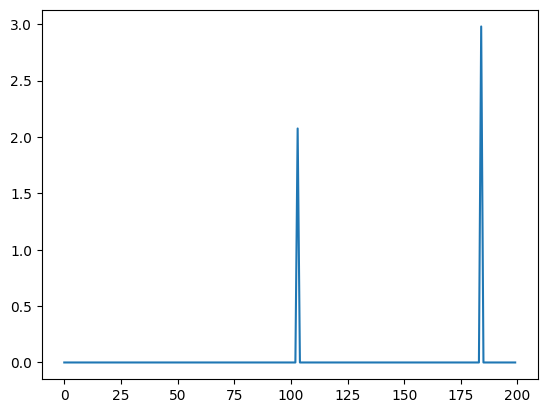

In [10]:
#plot the backscatter coefficients 
#ToDO : make a better more random way of choosing the heights
#ToDO : study rayleigh's resolution and the stuff linked with it in the paper
n_scatterers = 2
height = None

# n_scatterers = 1
# height = 50

gamma = generate_gamma(n_scatterers)

plt.plot([np.abs(gamma[k]) for k in range(len(gamma))])

In [ ]:
baselines = compute_baseline_lengths()
D = compute_measurement_matrix(baselines, n_grids, lambda_c, R0)
print(D.shape)

#generate y 
y = np.dot(D,gamma)
#ToDO add the noise to have the correct SNR for all the values mentionned
print(y)


(25, 200)
[-7.87096581e-01+1.28004093j -5.43113861e-02-3.35277125j
  2.99411090e+00-4.30229948j  3.23813645e+00-1.1626899j
 -8.15631601e-01+1.16173177j -4.63203185e+00-0.47057522j
 -3.78691590e+00-3.01686703j -4.57989688e-03-1.74831542j
  1.41917340e+00+2.76249206j -8.82083601e-01+5.15295103j
 -2.56610578e+00+2.62866756j -1.10975224e-02-1.21616695j
  4.23980927e+00-1.50442096j  4.82314841e+00+1.1420972j
  1.00536717e+00+1.73861254j -2.29889462e+00-1.68381767j
 -1.38057667e+00-5.00730593j  1.23871607e+00-3.69185935j
  6.85906536e-01+0.82247276j -3.06127838e+00+3.05524869j
 -4.94454093e+00+1.0388692j  -1.94262553e+00-1.18296115j
  2.55373331e+00+0.41351669j  3.34216385e+00+3.90568985j
  5.05082739e-01+4.0698927j ]


In [ ]:

model = AtasiNet(D)
W = model.compute_w()
print(W.shape)
print(D.shape)
score = np.linalg.norm(W.T@D)**2
print(score)


/home/guacaman/.virtualenvs/IMA/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/home/guacaman/.virtualenvs/IMA/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:422: ComplexWarning: Casting complex values to real discards the imaginary part
  slsqp(m, meq, x, xl, xu, fx, c, g, a, acc, majiter, mode, w, jw,


cristiano.ulondumendes@telecom-paris.fr